<IPython.core.display.Javascript object>


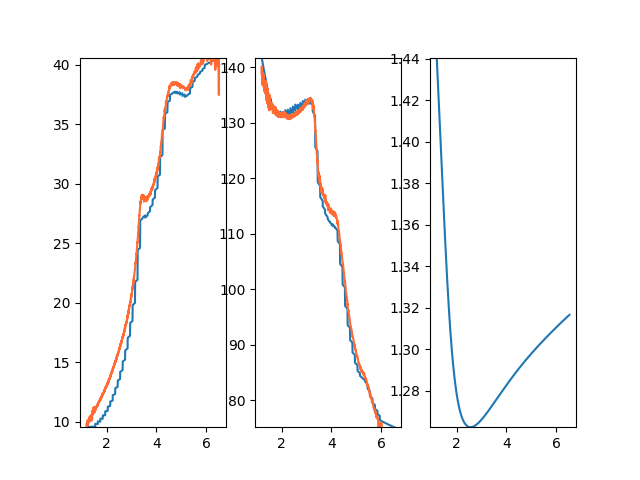

/Users/daria/opt/anaconda3/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from ipywidgets import interact, interactive, fixed, interact_manual
import tmm.tmm as tmm
import tmm.models as models
import tmm.tools as tools
import pandas as pd
import time

data = np.loadtxt('data/ytas2/247_0_Psi,Delta_190-3500_70deg.csv',skiprows=1)
phi = 70
name='s247'

# x axis in nm 
cutoff = 1900 # approx 1000 nm (step not taken into account)
omegas = 1240/data[0:cutoff,0] # grid in eV
# basically all energy units in eV, al length scales in nm

si = pd.read_csv('data/ytas2/RefractiveIndexSI.csv')
tab_si_grid = si['Photon energy, eV'].to_numpy()
tab_si_n = si['n'].to_numpy()
tab_si_k= si['k'].to_numpy()

sio2dat = np.loadtxt('data/ytas2/RefractiveIndexSIO2.txt', delimiter=" ", dtype=float, encoding='utf-8-sig')
tab_sio2_grid = sio2dat[:,0]
tab_sio2_n  = sio2dat[:,1]
tab_sio2_k = np.zeros(tab_sio2_n.shape[0]) # transparent 

si_ad = tools.grid_adapt(omegas, tab_si_grid, tab_si_n, tab_si_k)
sio2_ad = tools.grid_adapt(omegas, tab_sio2_grid, tab_sio2_n, tab_sio2_k)

lambd = 1240/omegas

psi = np.zeros(omegas.shape[0],dtype=np.float64)
delta = np.zeros(omegas.shape[0],dtype=np.float64)

%matplotlib notebook
import ipywidgets as wg

dx=11.3
dox=5.5
einf=1.19

wp0=0.69
wp1=0.36
wp2=0.58

w00=0
w01=1.53
w02=5.42

g0=1.68
g1=1.28
g2=5.09

d_min = 5
d_max = 100
d_fit = np.array([0],dtype=float)

dox_min = 2
dox_max = 20
dox_fit = np.array([0],dtype=float)

einf_min = 1
einf_max = 5
einf_fit = np.array([0],dtype=float)

wp_min = 0
wp_max = 12
wp0_fit = np.array([0],dtype=float)
wp1_fit = np.array([0],dtype=float)
wp2_fit = np.array([0],dtype=float)

w0_min = 0
w0_max = 7
w00_fit = np.array([0],dtype=float)
w01_fit = np.array([0],dtype=float)
w02_fit = np.array([0],dtype=float)

g_min = 0
g_max = 25.5
g0_fit = np.array([0],dtype=float)
g1_fit = np.array([0],dtype=float)
g2_fit = np.array([0],dtype=float)

dx_slide = wg.FloatSlider(min=d_min,max=d_max,step= .00001,value=dx)
dox_slide = wg.FloatSlider(min=d_min,max=d_max,step= .00001,value=dox)
einf_slide = wg.FloatSlider(min=einf_min,max=einf_max,step= .00001,value=einf)

wp0_slide = wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value=wp0)
wp1_slide = wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value=wp0)
wp2_slide = wg.FloatSlider(min=wp_min,max=wp_max,step= .00001,value=wp0)
w00_slide = wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value=w00)
w01_slide = wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value=w01)
w02_slide = wg.FloatSlider(min=w0_min,max=w0_max,step= .00001,value=w02)
g0_slide = wg.FloatSlider(min=g_min,max=g_max,step= .00001,value=g0)
g1_slide = wg.FloatSlider(min=g_min,max=g_max,step= .00001,value=g1)
g2_slide = wg.FloatSlider(min=g_min,max=g_max,step= .00001,value=g2)

#dox=5.5 # fitted substrate
A=1.4563
B=3500 # in units nm**2

nair = np.ones(omegas.shape[0])
nox = models.Cauchy(A,B,lambd)
nsi = si_ad
ex = np.zeros(omegas.shape[0],dtype=np.complex128)
for l in range(omegas.shape[0]):
    ex[l] = (einf+models.DrudeLorentz(wp0,w00,g0,omegas[l])+
              models.DrudeLorentz(wp1,w01,g1,omegas[l])+
              models.DrudeLorentz(wp2,w02,g2,omegas[l]))
nx = np.sqrt(ex) # epsilon to refractive index

n = np.array([nair,nx,nox,nsi]) # nsi here will be from table
# nox from fit of substrate
# nx fit with 3 DL osc

fig, ax =  plt.subplots(1,3)

line_psi, = ax[0].plot(omegas, psi)
line_delta, = ax[1].plot(omegas, delta)

line_psi_data = ax[0].plot(omegas,data[:cutoff,1],c='#FF6B33')
line_delta_data = ax[1].plot(omegas,data[:cutoff,2],c='#FF6B33')

line_refr_nt, = ax[2].plot(omegas,nx)
#nx_paper = models.DrudeLorentz(23.48,2.1721,2.1253,0.02,omegas)
nx_paper=4.5*np.ones(omegas.shape[0])
line_refr_nt_paper = ax[2].plot(omegas, nx_paper) 


def update(dx=dx_slide, dox=dox_slide, einf=einf_slide,
           wp0=wp0_slide, w00=w00_slide, g0=g0_slide,
           wp1=wp1_slide, w01=w01_slide, g1=g1_slide,
           wp2=wp2_slide, w02=w02_slide, g2=g2_slide
          ):
    ex = np.zeros(omegas.shape[0],dtype=np.complex128)
    for l in range(omegas.shape[0]):
        ex[l] = (einf+models.DrudeLorentz(wp0,w00,g0,omegas[l])+
                  models.DrudeLorentz(wp1,w01,g1,omegas[l])+
                  models.DrudeLorentz(wp2,w02,g2,omegas[l]))
    nx = np.sqrt(ex) # epsilon to refractive index
    n = np.array([nair,nx,nox,nsi])
    d = np.array([0,dx,dox,0])
    for ind in range(omegas.shape[0]):
        psi[ind] = tmm.solve_psi(n[:,ind],d,phi,lambd[ind])
        delta[ind] = tmm.solve_delta(n[:,ind],d,phi,lambd[ind])
    #delt = corr_delta(delta)
    delt=delta
    
    line_psi.set_ydata(psi)
    line_delta.set_ydata(delt)
    line_refr_nt.set_ydata(nx)
    
    ax[0].set_ylim([np.min(psi), np.max(psi)])
    ax[1].set_ylim([np.min(delt), np.max(delt)])
    ax[2].set_ylim([np.min(nx), np.max(nx)])
    
    fig.canvas.draw_idle()
    
    d_fit[0] = dx
    dox_fit[0] = dox
    einf_fit[0] = einf
    
    wp0_fit[0] = wp0
    wp1_fit[0] = wp1
    wp2_fit[0] = wp2
    w00_fit[0] = w00
    w01_fit[0] = w01
    w02_fit[0] = w02
    g0_fit[0] = g0
    g1_fit[0] = g1
    g2_fit[0] = g2

sliders = [dx_slide,dox_slide,einf_slide]
common = wg.VBox(sliders)
sliders = [wp0_slide,w00_slide,g0_slide]
osc1 = wg.VBox(sliders)
sliders = [wp1_slide,w01_slide,g1_slide]
osc2 = wg.VBox(sliders)
sliders = [wp2_slide,w02_slide,g2_slide]
osc3 = wg.VBox(sliders)  
    
wg.interactive(update)

display(wg.HBox([common, osc1, osc2, osc3]))

In [2]:
plt.close()

<ipython-input-2-60fa62c0aada>:1: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close()


In [4]:
import sys
import os
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
import scipy

import refnx
from refnx.analysis import CurveFitter
from refnx.reflect import Slab

import refellips
from refellips.dataSE import DataSE, open_EP4file
from refellips.reflect_modelSE import ReflectModelSE
from refellips.objectiveSE import ObjectiveSE
from refellips.structureSE import *
from refellips.dispersion import RI, Cauchy, load_material, Lorentz, TaucLorentz

angles = phi*np.ones(data[:,0].shape[0])
datacorr = np.column_stack([data[:cutoff,0],angles[:cutoff],data[:cutoff,1],data[:cutoff,2]])
np.savetxt('data/ytas2/'+name+'.dat',datacorr)
Data = DataSE(data='data/ytas2/'+name+'.dat', delimiter=' ')

si = load_material("silicon")
#sio2 = RI([1.4563, 0]) # silica layer
sio2 = load_material("silica")
air = load_material("air")

silica_layer = sio2(55.0) # fitted
silica_layer.name = "Silica"
silica_layer.thick.setp(vary=False, bounds=(30, 200))
silica_layer.vfsolv.setp(vary=False, value=0)

A = [wp0_fit[0]**2, wp1_fit[0]**2, wp2_fit[0]**2]
B = [g0_fit[0], g1_fit[0], g2_fit[0]]
E = [w00_fit[0], w01_fit[0], w02_fit[0]]

Einf = einf_fit[0]
s247 = Lorentz(A,B,E,Einf)
s247_layer = s247(10*d_fit[0]) # previous fit; nm -> angstrom in argument
s247_layer.name = "S247"

s = air | s247_layer | silica_layer | si

s247_layer.thick.setp(vary=True, bounds=(70, 800))
s247_layer.ri._parameters[0][0].setp(vary=True, bounds=(0,12.1)) # wp0**2
s247_layer.ri._parameters[0][1].setp(vary=False, bounds=(0,25.2)) # wp1**2
s247_layer.ri._parameters[0][2].setp(vary=False, bounds=(0,25.3)) # wp2**2
s247_layer.ri._parameters[1][0].setp(vary=True, bounds=(0,15.1))  # g0
s247_layer.ri._parameters[1][1].setp(vary=False, bounds=(0,25.1))  # g1
s247_layer.ri._parameters[1][2].setp(vary=False, bounds=(0,25.2))  # g2
s247_layer.ri._parameters[2][0].setp(vary=False, bounds=(0,5))               # w00 Drude
s247_layer.ri._parameters[2][1].setp(vary=False, bounds=(0,7.5))  # w01
s247_layer.ri._parameters[2][2].setp(vary=False, bounds=(0,7.5))  # w02
s247_layer.ri._parameters[3].setp(vary=True, bounds=(0.9,3))     # einf
s247_layer.vfsolv.setp(vary=False, value=0.0)
s247_layer.rough.setp(vary=False,bounds=(0,20))



model = ReflectModelSE(s)

objective = ObjectiveSE(model, Data)

fitter = CurveFitter(objective)
fitter.fit(method="least_squares");

for i, x in enumerate(objective.model.parameters):
    print(x)

________________________________________________________________________________
Parameters: 'instrument parameters'
<Parameter:'delta offset' , value=0 (fixed)  , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:  ' - thick'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:  ' - rough'   , value=0 (fixed)  , bounds=[-inf, inf]>
<Parameter:' - volfrac solvent', value=0 (fixed)  , bounds=[0.0, 1.0]>
________________________________________________________________________________
Parameters:     'S247'     
<Parameter:  ' - thick'   , value=94.7939 +/- 0.636, bounds=[70.0, 800.0]>
________________________________________________________________________________
Parameters:      None      
<Parameter:      ''       , value=9.36871 +/- 0.122, bounds=[0.0, 12.1]>
<Parameter:      ''       ,

<IPython.core.display.Javascript object>


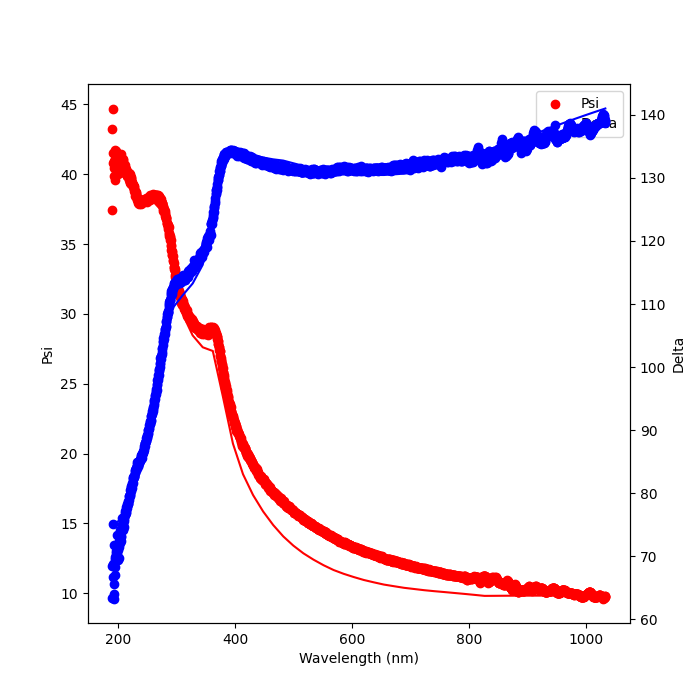

(<Figure size 700x700 with 2 Axes>,
 <AxesSubplot: xlabel='Wavelength (nm)', ylabel='Psi'>)

In [5]:
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)

objective.plot(fig=fig)

<IPython.core.display.Javascript object>


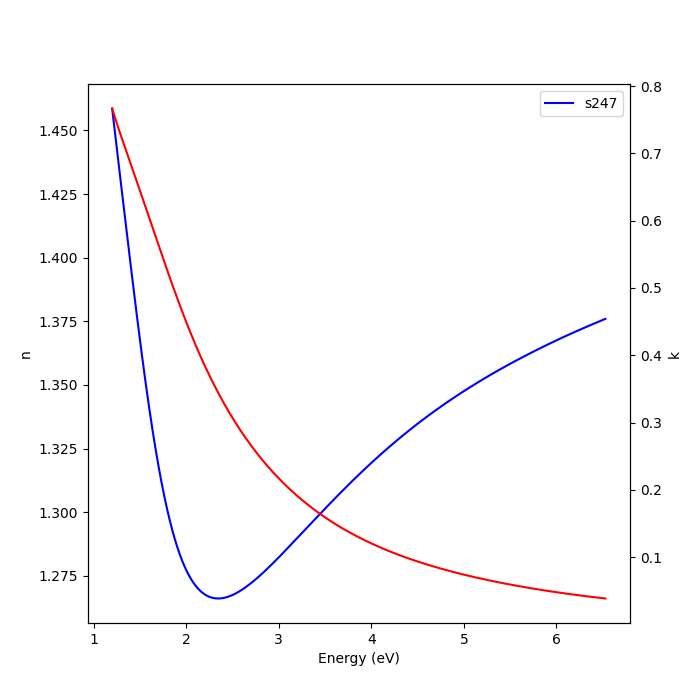

In [7]:
n = np.real(np.sqrt(objective.model._structure[1].ri.epsilon(omegas)))
k = np.imag(np.sqrt(objective.model._structure[1].ri.epsilon(omegas)))

plt.close()
fig, ax = plt.subplots()
axt = ax.twinx()
fig.set_figheight(7)
fig.set_figwidth(7)
line=ax.plot(omegas, n, color="b")
axt.plot(omegas, k, color="r")
ax.set(ylabel="n")
axt.set(ylabel="k")
ax.legend(line,[name])
ax.set_xlabel('Energy (eV)')
plt.show()

In [8]:
optconsts = np.column_stack([lambd,n,k])
np.savetxt('nk_'+name+'.dat',optconsts)
mse = np.sqrt(objective.chisqr()/(2*omegas.shape[0]))
mse

1.5673995949542656